# EWMAC Strategy

EWMAC(Exponentially Weighted Moving Average Crossover) trading rule in the book "Systematic Trading".

In [1]:
import glob
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
ANNUAL_VOLATILITY = 0.5  # 50%, how much can you afford to lose?
DAILY_VOLATILITY = ANNUAL_VOLATILITY / np.sqrt(365)
TRADING_CAPITAL = 10000  # $10,000

In [3]:
# Choices: 2,8; 4,16; 8,32; 16,64; 32,128; 64,256
WINDOW_SIZE_FAST = 32
WINDOW_SIZE_SLOW = 128
VOLATILITY_LOOKBACK = 25

## 1. Read Data

In [4]:
BARS_DIR = '/data/bars'

In [5]:
from utils import read_bars as read_bars_tmp

def read_bars(csv_file: str)->pd.DataFrame:
    TIME_BEGIN = pd.to_datetime('2020-05-12T00:00:00.000Z')
    TIME_END = pd.to_datetime('2020-05-14T00:00:00.000Z')
    bars_df = read_bars_tmp(csv_file)
    bars_df = bars_df[(bars_df['timestamp'] >= TIME_BEGIN) & (bars_df['timestamp_end'] < TIME_END)]
    return bars_df

In [6]:
time_bars = read_bars(f'{BARS_DIR}/TimeBar/60000/TimeBar.60000.OKEx.Swap.BTC_USDT.csv')

In [7]:
time_bars

,exchange,market_type,pair,bar_type,bar_size,timestamp,timestamp_end,open,high,low,...,volume,volume_sell,volume_buy,volume_quote,volume_quote_sell,volume_quote_buy,count,count_sell,count_buy,vwap
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-05-12 00:00:00+00:00,OKEx,Swap,BTC_USDT,TimeBar,60000,2020-05-12 00:00:00+00:00,2020-05-12 00:01:00+00:00,8561.299805,8561.400391,8540.500000,...,43.630000,18.380000,25.25,373135.530,157213.750,373117.160,176,93,83,8552.269769
2020-05-12 00:01:00+00:00,OKEx,Swap,BTC_USDT,TimeBar,60000,2020-05-12 00:01:00+00:00,2020-05-12 00:02:00+00:00,8546.900391,8566.700195,8546.900391,...,38.460000,10.970000,27.49,329172.940,93876.210,329161.970,164,50,114,8558.838794
2020-05-12 00:02:00+00:00,OKEx,Swap,BTC_USDT,TimeBar,60000,2020-05-12 00:02:00+00:00,2020-05-12 00:03:00+00:00,8564.500000,8564.500000,8528.000000,...,59.260000,27.810000,31.45,506129.440,237557.360,506101.620,250,144,106,8540.827540
2020-05-12 00:03:00+00:00,OKEx,Swap,BTC_USDT,TimeBar,60000,2020-05-12 00:03:00+00:00,2020-05-12 00:04:00+00:00,8539.000000,8550.000000,8536.500000,...,32.370000,13.559999,18.81,276632.620,115889.600,276619.060,158,98,60,8545.956750
2020-05-12 00:04:00+00:00,OKEx,Swap,BTC_USDT,TimeBar,60000,2020-05-12 00:04:00+00:00,2020-05-12 00:05:00+00:00,8548.000000,8574.400391,8548.000000,...,9.370000,1.010000,8.36,80233.650,8650.083,80232.640,95,21,74,8562.822839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-13 23:54:00+00:00,OKEx,Swap,BTC_USDT,TimeBar,60000,2020-05-13 23:54:00+00:00,2020-05-13 23:55:00+00:00,9302.400391,9303.900391,9300.500000,...,8.620000,1.770000,6.85,80180.650,16464.178,80178.880,51,15,36,9301.699536
2020-05-13 23:55:00+00:00,OKEx,Swap,BTC_USDT,TimeBar,60000,2020-05-13 23:55:00+00:00,2020-05-13 23:56:00+00:00,9304.000000,9305.000000,9303.000000,...,2.620000,1.260000,1.36,24376.096,11723.173,24374.834,19,9,10,9303.853080
2020-05-13 23:56:00+00:00,OKEx,Swap,BTC_USDT,TimeBar,60000,2020-05-13 23:56:00+00:00,2020-05-13 23:57:00+00:00,9302.400391,9302.900391,9289.099609,...,30.870000,18.270000,12.60,286990.970,169886.390,286972.700,242,139,103,9296.759637


## 2. Plot Price and EWMAs

In [10]:
prices = time_bars['vwap'].rename('price')

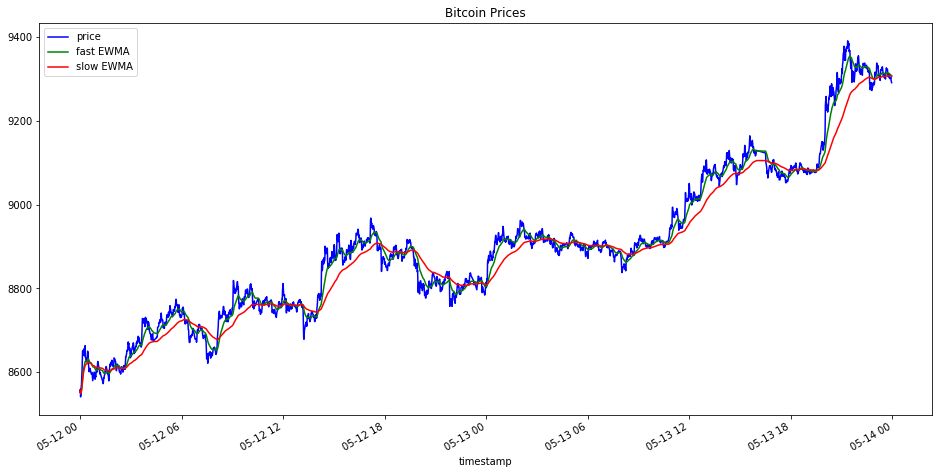

In [11]:
fig, ax = plt.subplots(figsize=(16, 8))
prices.plot(title="Bitcoin Prices", color='blue', label='price')
prices.ewm(span=WINDOW_SIZE_FAST).mean().plot(ax=ax, color='green', label='fast EWMA')
prices.ewm(span=WINDOW_SIZE_SLOW).mean().plot(ax=ax, color='red', label='slow EWMA')
plt.legend()

## 3. Raw EWMAC

In [12]:
ewma_fast = prices.ewm(span=30).mean()
ewma_slow = prices.ewm(span=120).mean()
ewmac_raw = ewma_fast- ewma_slow

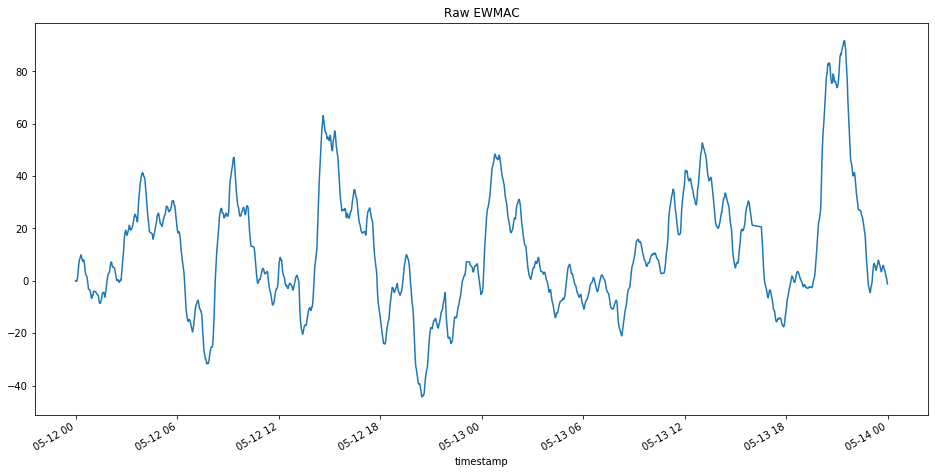

In [13]:
fig, ax = plt.subplots(figsize=(16, 8))

ewmac_raw.plot(title = 'Raw EWMAC', ax=ax)

## 4. Volatility Standardization

In [14]:
stdev_returns = prices.diff().ewm(span=VOLATILITY_LOOKBACK).std()
ewmac_volatility_standardized = ewmac_raw / stdev_returns

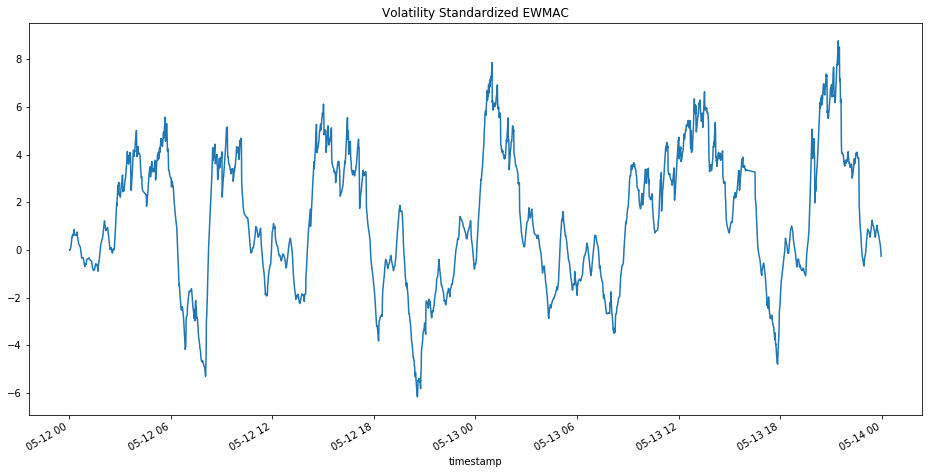

In [15]:
fig, ax = plt.subplots(figsize=(16, 8))

ewmac_volatility_standardized.plot(title = 'Volatility Standardized EWMAC', ax=ax)

## 5. Scaling to 10

In [16]:
def calc_forecast_scalar(forecasts: pd.Series)->float:
    forcast_scalar = 10 / forecasts.abs().mean()
    return forcast_scalar

In [17]:
forcast_scalar = calc_forecast_scalar(ewmac_volatility_standardized)

In [18]:
forcast_scalar

3.996884815884032

In [19]:
forecasts = ewmac_volatility_standardized * forcast_scalar

In [20]:
forecasts.abs().mean()

10.000000000000014

Ensure that the average absolute value of forecasts is 10.

## 6. Capped at 20

In [21]:
forecasts_capped = forecasts.clip(lower=-20.0, upper=20.0)

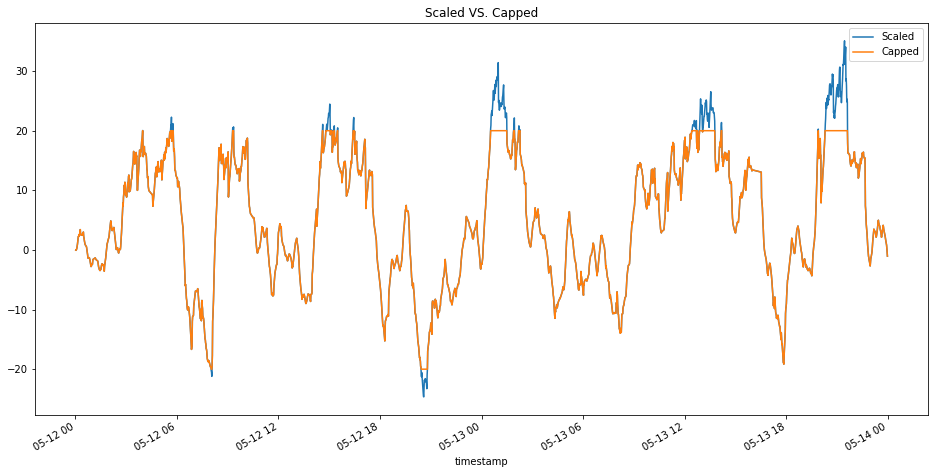

In [22]:
fig, ax = plt.subplots(figsize=(16, 8))

forecasts.plot(title="Scaled VS. Capped", ax=ax, label='Scaled')
forecasts_capped.plot(ax=ax, label='Capped')
plt.legend()

## 7. Calculate Position Size

In [23]:
positions = forecasts_capped *  TRADING_CAPITAL * DAILY_VOLATILITY / 10

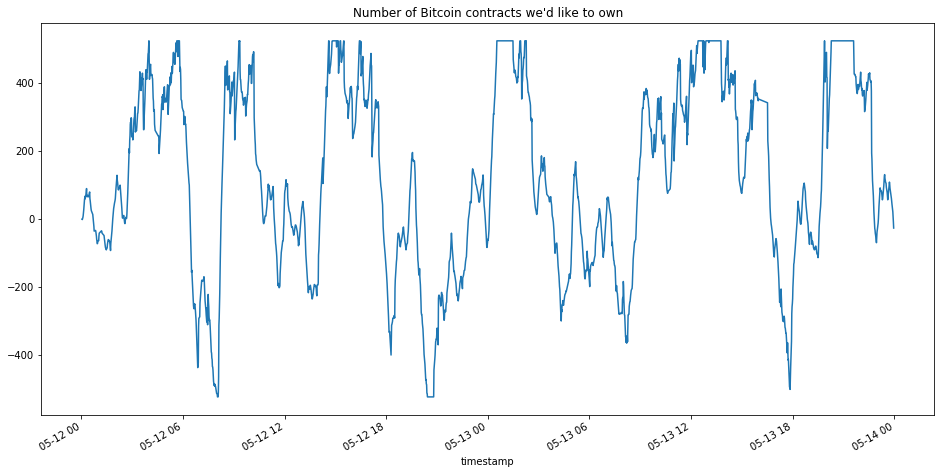

In [24]:
fig, ax = plt.subplots(figsize=(16, 8))
positions.round().plot(title='Number of Bitcoin contracts we\'d like to own', ax=ax)

## References

* [PyTrendFollow/docs/Introduction to Trend Following.ipynb](https://github.com/chrism2671/PyTrendFollow/blob/master/docs/Introduction%20to%20Trend%20Following.ipynb)
* [robcarver17/systematictradingexamples/ewmac.py](https://github.com/robcarver17/systematictradingexamples/blob/master/ewmac.py)
* [robcarver17/systematictradingexamples/tradingrules.py](https://github.com/robcarver17/systematictradingexamples/blob/master/tradingrules.py)
* 2015, Robert Carver, Systematic Trading, Appendix B. Trading Rules